In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install numpy pandas nltk tabulate tqdm scikit-learn torch transformers

In [3]:
# Import standard libraries
import json
import time
import datetime
import gc
import random
import re

# Import data handling libraries
import numpy as np
import pandas as pd

# Import NLP libraries
import nltk
from nltk.corpus import stopwords

# Import utilities for displaying and progress tracking
from tabulate import tabulate
from tqdm import trange

# Import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report

# Import PyTorch libraries
import torch
import torch.nn as nn
from torch.utils.data import (
    TensorDataset,
    DataLoader,
    RandomSampler,
    SequentialSampler,
    random_split
)


# Import Transformers library components
import transformers
from transformers import (
    BertForSequenceClassification,
    AdamW,
    BertConfig,
    BertTokenizer,
    get_linear_schedule_with_warmup
)


In [4]:
#verificare la disponibilità di cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## ETL

In [5]:
# Scarica le stopwords
nltk.download('stopwords')
sw = stopwords.words('english')

# Definizione della funzione clean_text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
    text = re.sub(r"http\S+", "", text)
    html = re.compile(r'<.*?>')
    text = html.sub(r'', text)
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p, '')
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    text = " ".join(text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/wangrongsheng/ag_news/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/wangrongsheng/ag_news/" + splits["test"])

# World (0), Sports (1), Business (2), Sci/Tech (3).

df['label'].value_counts()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,count
label,
2,30000
3,30000
1,30000
0,30000


In [7]:
# Uniamo i due dataset
df_combined = pd.concat([df, df_test])

# Contiamo le occorrenze di ciascuna classe nel dataset combinato
class_counts = df_combined['label'].value_counts()
print(class_counts)

# Per ogni classe, prendiamo solo 4400 elementi
df_final = df_combined.groupby('label').apply(lambda x: x.sample(n=5000, random_state=42))

# Rimuoviamo l'indice multi-livello creato dal groupby
df_final = df_final.reset_index(drop=True)

# Controlliamo che abbiamo 4400 elementi per classe
print(df_final['label'].value_counts())

label
2    31900
3    31900
1    31900
0    31900
Name: count, dtype: int64
label
0    5000
1    5000
2    5000
3    5000
Name: count, dtype: int64


<ipython-input-7-1936d8289086>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_final = df_combined.groupby('label').apply(lambda x: x.sample(n=5000, random_state=42))


In [8]:
df_final['text'] = df_final['text'].apply(clean_text)

In [9]:
test_val_size = 0.1 * len(df_final)

In [10]:
# Eseguiamo lo split 90% - 10%
df_train, df_test = train_test_split(df_final, test_size= test_val_size / len(df_final), random_state=42)

# Verifichiamo le dimensioni dei dataset risultanti
print(f"Training set size: {df_train.shape}")
print(f"Test set size: {df_test.shape}")


Training set size: (18000, 2)
Test set size: (2000, 2)


In [11]:
sentences = list(df_train['text'])
labels = list(df_train['label'])

## Tokenizzazione

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
index=0
print(' Original: ', sentences[index])

table = np.array([tokenizer.tokenize(sentences[index]),
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[index]))]).T
print(tabulate(table,headers = ['Tokens', 'Token IDs'],tablefmt = 'fancy_grid'))


 Original:  cameras lead gadget price declines october npd new york reuters digital cameras led retail price declines us consumer electronics october, manufacturers looked clear older models ahead holiday shopping season, according industry study prepared reuters
╒═══════════════╤═════════════╕
│ Tokens        │   Token IDs │
╞═══════════════╪═════════════╡
│ cameras       │        8629 │
├───────────────┼─────────────┤
│ lead          │        2599 │
├───────────────┼─────────────┤
│ ga            │       11721 │
├───────────────┼─────────────┤
│ ##dget        │       24291 │
├───────────────┼─────────────┤
│ price         │        3976 │
├───────────────┼─────────────┤
│ declines      │       26451 │
├───────────────┼─────────────┤
│ october       │        2255 │
├───────────────┼─────────────┤
│ np            │       27937 │
├───────────────┼─────────────┤
│ ##d           │        2094 │
├───────────────┼─────────────┤
│ new           │        2047 │
├───────────────┼─────────────┤


## Add special token

In [14]:
max_len = 0
min_len = float('inf')
total_len = 0
num_sentences = len(sentences)

# Per ogni frase...
for sentence in sentences:
    # Tokenizza il testo e aggiungi i token `[CLS]` e `[SEP]`.
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)

    # Aggiorna la lunghezza massima e minima.
    max_len = max(max_len, len(input_ids))
    min_len = min(min_len, len(input_ids))
    total_len += len(input_ids)

# Calcola la lunghezza media
avg_len = total_len / num_sentences if num_sentences > 0 else 0

print('Lunghezza massima della frase: ', max_len)
print('Lunghezza minima della frase: ', min_len)
print('Lunghezza media della frase: ', avg_len)

Lunghezza massima della frase:  171
Lunghezza minima della frase:  12
Lunghezza media della frase:  33.08844444444444


In [15]:
MAX_LEN = 64
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Encoding

In [16]:
# Print sentence 0, now as a list of IDs.
i=random.randint(0,len(sentences)-1)
print('Original: ', sentences[i])
print('Input IDs:', input_ids[i])

Original:  saints behaviour unacceptable barnwell southampton told quot unacceptable quot parted company manager paul sturrock two games barclays premiership season
Input IDs: tensor([  101,  6586,  9164, 21873,  8659,  4381, 11833,  2409, 22035,  2102,
        21873, 22035,  2102, 10277,  2194,  3208,  2703, 24646, 18933,  3600,
         2048,  2399, 23724,  2015, 11264,  2161,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [17]:
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(sentences) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(input_ids[index]))
  token_ids = [i.numpy() for i in input_ids[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(sentences[index])
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

oracle may drop peoplesoft lawsuit oracle says nix claim unless peoplesoft shareholders agree sell least half holdings nov
╒══════════════╤═════════════╤══════════════════╕
│ Tokens       │   Token IDs │   Attention Mask │
╞══════════════╪═════════════╪══════════════════╡
│ [CLS]        │         101 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ oracle       │       14721 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ may          │        2089 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ drop         │        4530 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ peoples      │        7243 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ ##oft        │       15794 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ lawsuit      │        9870 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ oracle       │       1472

## Train Validation Split

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

# Dataset originale
dataset = TensorDataset(input_ids, attention_masks, labels)

# Suddivisione stratificata
sss = StratifiedShuffleSplit(n_splits=1, test_size=(int(test_val_size)*3), random_state=42)

# Estrai gli indici di addestramento e validazione
for train_index, val_index in sss.split(input_ids, labels):
    train_dataset = torch.utils.data.Subset(dataset, train_index)
    val_dataset = torch.utils.data.Subset(dataset, val_index)

train_size = len(train_dataset)
print(f'{train_size:,} training samples')
print(f'{len(val_dataset):,} validation samples')


12,000 training samples
6,000 validation samples


In [19]:
#Per eseguire il fine-tuning di BERT su un task specifico, è raccomandata una dimensione del batch pari a 16 o a 32
batch_size = 32

#Crea il DataLoaders per il training set e per il validation set
#Vengono presi gli elementoi del training set in ordine randomico
train_dataloader = DataLoader(
            train_dataset,  #Il training set
            sampler = RandomSampler(train_dataset), #Seleziona randomicamente i batch
            batch_size = batch_size #Esegue l'allenamento con questa dimensione dei batch
        )


validation_dataloader = DataLoader(
            val_dataset, #Il validation set
            sampler = SequentialSampler(val_dataset), #Seleziona i batch in maniera sequenziale
            batch_size = batch_size #Esegue una valutazione del modello con questa dimensione dei batch
        )

## Metrics

In [20]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

## Creazione modello BERT

In [21]:
# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 4, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# if device == "cuda:0":
# # Tell pytorch to run this model on the GPU.
#     model = model.cuda()
model = model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Fine-tuning

In [23]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [24]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [25]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [26]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs"
        model.zero_grad()
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value;
        loss = output.loss
        logits = output.logits
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.

    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    best_eval_accuracy = np.Inf
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            output= model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    #save the best model
    if avg_val_accuracy < best_eval_accuracy:
        torch.save(model, 'bert_model_bbc')
        best_eval_accuracy = avg_val_accuracy

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...

  Average training loss: 0.41
  Training epcoh took: 0:02:04

Running Validation...
  Accuracy: 0.91
  Validation Loss: 0.28
  Validation took: 0:00:21

======== Epoch 2 / 2 ========
Training...

  Average training loss: 0.21
  Training epcoh took: 0:02:04

Running Validation...
  Accuracy: 0.92
  Validation Loss: 0.25
  Validation took: 0:00:21

Training complete!
Total training took 0:04:53 (h:mm:ss)


## Training stats

In [27]:
import pandas as pd


df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.411426,0.275537,0.909574,0:02:04,0:00:21
2,0.211521,0.253298,0.917387,0:02:04,0:00:21


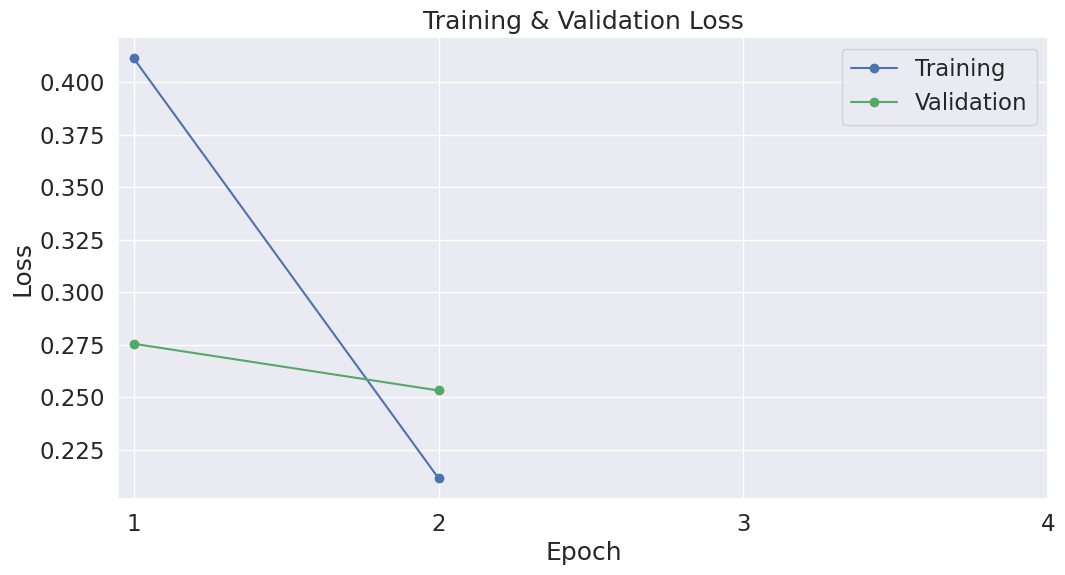

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


sns.set(style='darkgrid')


sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)


plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")


plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## Loading best model

In [29]:
model = torch.load('bert_model_bbc')

<ipython-input-29-bf83ec30bc0b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('bert_model_bbc')


## Test

In [30]:
# Create sentence and label lists
sentences = list(df_test['text'])
labels = list(df_test['label'])
MAX_LEN = 128

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )


    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [31]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))


model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,000 test sentences...
    DONE.


In [32]:
from functools import reduce
scores = reduce(lambda x,y: x+y,[list(map(np.argmax,p)) for p in predictions])
labels = reduce(lambda x,y: list(x) + list(y), true_labels)

from sklearn.metrics import accuracy_score
accuracy_score(scores, labels)

0.926

## Confusion matrix

In [33]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

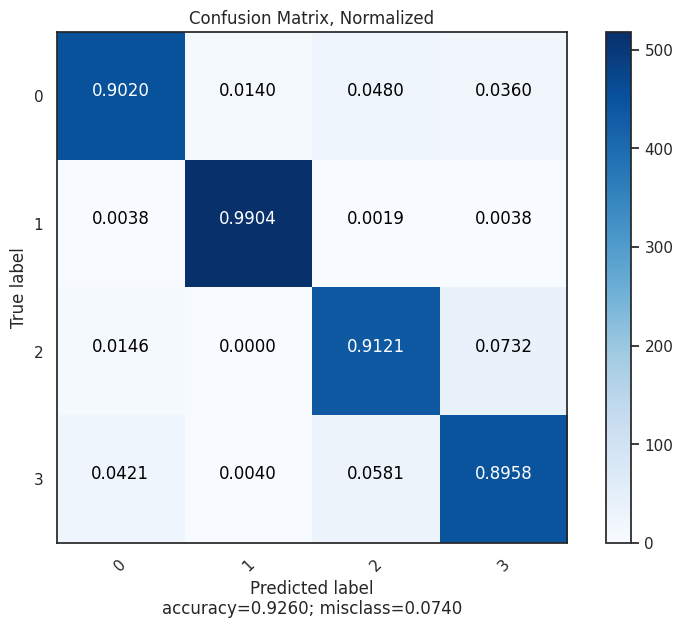

In [34]:
from sklearn.metrics import confusion_matrix

sns.set(font_scale=1)
sns.set(style='white')


cm = confusion_matrix(labels,scores)
plot_confusion_matrix(cm           = cm,
                      normalize    = True,
                      target_names = ['0', '1', '2','3'],
                      title        = "Confusion Matrix, Normalized")